<a href="https://colab.research.google.com/github/bottic/CV_project_yandex/blob/main/workm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchsummary import summary

# Подготовка тренировочного датасета

Загрезим наши данные и сохраним их на гугл диске

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nikitatalent","key":"e56f0cbde5a097c96bd8bdb38643850a"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle

In [8]:
!kaggle competitions download -c ml-intensive-yandex-academy-autumn-2024

100% 7.90G/7.90G [06:09<00:00, 24.0MB/s]
100% 7.90G/7.90G [06:09<00:00, 22.9MB/s]


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!cp ml-intensive-yandex-academy-autumn-2024.zip /content/drive/MyDrive/

In [11]:
!unzip ml-intensive-yandex-academy-autumn-2024.zip -d ./dataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./dataset/human_poses_data/img_train/3413.jpg  
  inflating: ./dataset/human_poses_data/img_train/3414.jpg  
  inflating: ./dataset/human_poses_data/img_train/3417.jpg  
  inflating: ./dataset/human_poses_data/img_train/3418.jpg  
  inflating: ./dataset/human_poses_data/img_train/3420.jpg  
  inflating: ./dataset/human_poses_data/img_train/3421.jpg  
  inflating: ./dataset/human_poses_data/img_train/3422.jpg  
  inflating: ./dataset/human_poses_data/img_train/3423.jpg  
  inflating: ./dataset/human_poses_data/img_train/3424.jpg  
  inflating: ./dataset/human_poses_data/img_train/3425.jpg  
  inflating: ./dataset/human_poses_data/img_train/3427.jpg  
  inflating: ./dataset/human_poses_data/img_train/3428.jpg  
  inflating: ./dataset/human_poses_data/img_train/3429.jpg  
  inflating: ./dataset/human_poses_data/img_train/3431.jpg  
  inflating: ./dataset/human_poses_data/img_train/3432.jpg  
  inflating: ./da

In [7]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("PyTorch CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(3, 3).to(device)
print("Tensor device:", x.device)

CUDA available: True
CUDA device name: Tesla T4
PyTorch CUDA version: 12.1
Tensor device: cuda:0


In [8]:
device

device(type='cuda')

In [9]:
pd.read_csv('/content/dataset/human_poses_data/train_answers.csv').head()

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6


In [10]:
categories = pd.read_csv('/content/dataset/human_poses_data/activity_categories.csv')

categories.head()

,id,category
0,0,sports
1,1,inactivity quiet/light
2,2,miscellaneous
3,3,occupation
4,4,water activities


In [11]:
id_to_category = dict(zip(categories['id'], categories['category']))

In [37]:
class HumanPoseDatasetWithAugmentation(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        """
        img_dir: Папка с изображениями (В моем случае, 'drive/MyDrive/DataSets/human_poses_data/img_train').
        csv_file: Путь к таблице с метками (например, 'train_answers.csv').
        transform: Трансформации для предобработки изображений.
        transform: Трансформации для аугментации изображений.
        """
        self.img_dir = img_dir
        self.labels = pd.read_csv(csv_file)  # Загружаем таблицу меток
        self.transform = transform
        self.transform_aug = transform_aug

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Достаем имя изображения и метку
        img_id = self.labels.iloc[idx, 0]  # img_id (имя изображения)
        label = self.labels.iloc[idx, 1]  # target_feature (метка)

        # Загружаем изображение
        img_path = os.path.join(self.img_dir, str(img_id)+'.jpg')
        image = Image.open(img_path).convert("RGB")  # Убедимся, что изображение в RGB

        # Применяем трансформации
        if self.transform:
            image = self.transform(image)

        return image, label


Добавим аугментацию изображений

In [49]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Изменяем размер изображений
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_aug = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(p=0.5), #разворачиваем изображение по горизонтали
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3), #изменение яркости и контраста
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [50]:
RANDOM_SEED = 52
generator = torch.Generator().manual_seed(RANDOM_SEED)

In [51]:
print(f"Available CPU cores: {os.cpu_count()}")

Available CPU cores: 2


In [52]:
dataset = HumanPoseDatasetWithAugmentation(
    img_dir='/content/dataset/human_poses_data/img_train',
    csv_file='/content/dataset/human_poses_data/train_answers.csv',
    transform=transform
)

dataset_aug = HumanPoseDatasetWithAugmentation(
    img_dir='/content/dataset/human_poses_data/img_train',
    csv_file='/content/dataset/human_poses_data/train_answers.csv',
    transform=transform_aug
)

print(len(dataset))

train_dataset, val_dataset = random_split(dataset, [int(0.9*len(dataset)), len(dataset) - int(0.9*len(dataset))], generator)
train_dataset_aug, val_dataset_aug = random_split(dataset_aug, [int(0.9*len(dataset_aug)), len(dataset_aug) - int(0.9*len(dataset_aug))], generator)

12367


In [53]:
# Функция для отображения изображений с подписями
def show_images_with_labels(dataset, id_to_category, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        # Достаем изображение и метку
        image, label = dataset[i]
        # img_name = dataset.labels.iloc[i, 0]  # Имя файла

        # Декодируем метку в категорию
        category = id_to_category[label] if id_to_category else label

        # # Отображаем изображение
        axes[i].imshow(image.permute(1, 2, 0))  # Преобразуем тензор в (H, W, C)

In [54]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=64, shuffle=True, num_workers=3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


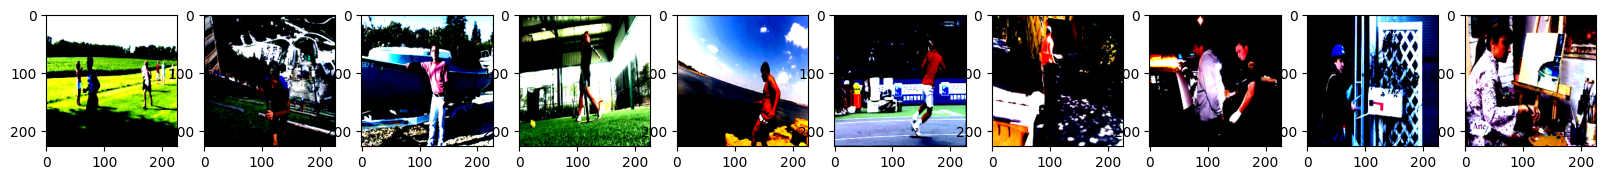

In [55]:
# Получить батч данных
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Вывести первые 10 изображений в одну строку
show_images_with_labels(train_dataset, id_to_category)

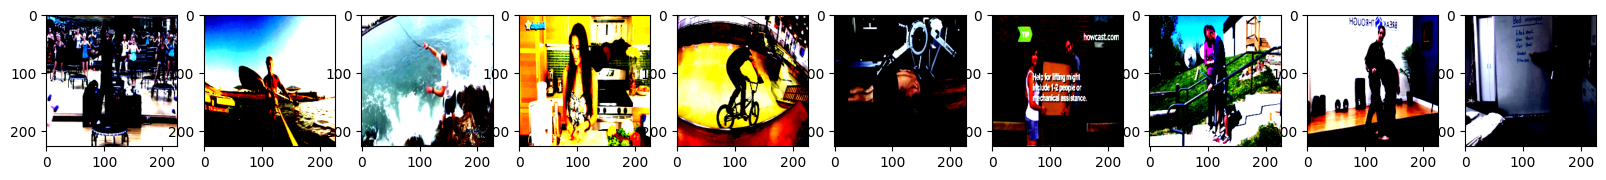

In [56]:
#выведем первые 10 изображений с аугментацией
show_images_with_labels(train_dataset_aug, id_to_category)

# Архитектуры

In [20]:
class AlexNetArtem(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetArtem, self).__init__()
        self.num_classes = num_classes
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0
            ),
            nn.ReLU(),
            nn.LocalResponseNorm(
                alpha=1e-4, beta=0.75, k=2, size=5
            ),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=96, out_channels=256, kernel_size=5, padding=2
            ),
            nn.ReLU(),
            nn.LocalResponseNorm(
                alpha=1e-4, beta=0.75, k=2, size=5
            ),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=384, kernel_size=3, padding=1
            ),
            nn.ReLU(),
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=384, out_channels=384, kernel_size=3, padding=1
            ),
            nn.ReLU(),
        )
        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(
                in_channels=384, out_channels=256, kernel_size=3, padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256 * 6 * 6, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(
                in_features=4096, out_features=self.num_classes
            ),
        )
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [21]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [22]:
len(id_to_category)

20

In [23]:
summary(AlexNet(20).to(device), (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]          23,296
              ReLU-2           [-1, 64, 56, 56]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14                 [-

# Обучение

In [24]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from ignite.engine import Engine, Events
from ignite.handlers import Checkpoint, DiskSaver, global_step_from_engine
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar
import logging
import tqdm

In [25]:
model = AlexNet(20).to(device)

In [26]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
weight_decay = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=weight_decay)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=3)

In [27]:
import time

time.localtime()

time.struct_time(tm_year=2024, tm_mon=12, tm_mday=8, tm_hour=10, tm_min=18, tm_sec=47, tm_wday=6, tm_yday=343, tm_isdst=0)

In [28]:
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',  # Или 'max', если метрика должна увеличиваться
    factor=0.5,  # Во сколько раз уменьшать learning rate
    patience=1,  # Сколько эпох ждать улучшений
    verbose=True,  # Выводить сообщения о снижении learning rate
    min_lr=1e-6  # Минимальное значение learning rate
)



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [43]:
!pip install pytorch-ignite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 17.0 MB/s eta 0:00:00


In [29]:
from ignite.handlers import EarlyStopping

# Определяем одну итерацию обучения (тренировочный шаг)
def train_step(engine, batch):
    model.train()  # Переводим модель в режим обучения
    images, labels = batch
    images, labels = images.to(device), labels.to(device)  # Перенос данных на устройство (CPU/GPU)
    optimizer.zero_grad()  # Обнуляем градиенты
    outputs = model(images)  # Прямой проход (forward pass)
    loss = criterion(outputs, labels)  # Вычисляем функцию потерь
    loss.backward()  # Вычисляем градиенты
    optimizer.step()  # Обновляем параметры модели
    # Возвращаем результаты: значение функции потерь, выходы модели и метки
    return {"loss": loss.item(), "outputs": outputs, "labels": labels}

# Определяем одну итерацию валидации
def val_step(engine, batch):
    model.eval()  # Переводим модель в режим оценки
    with torch.no_grad():  # Отключаем вычисление градиентов (ускоряет выполнение и экономит память)
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # Прямой проход
        return outputs, labels  # Возвращаем предсказания и истинные метки

# Создаём движки (engines) для тренировки и валидации
trainer = Engine(train_step)  # Движок для обучения
evaluator = Engine(val_step)  # Движок для валидации

# Создаём обработчик ранней остановки
handler = EarlyStopping(
    patience=7,  # Количество эпох без улучшений
    score_function=lambda engine: engine.state.metrics['loss'],  # Метрика для отслеживания
    trainer=trainer, # Остановка тренировки
    min_delta=0.01
)

evaluator.add_event_handler(Events.COMPLETED, handler)

# Добавляем метрики для обучения
train_loss = Loss(criterion, output_transform=lambda x: (x["outputs"], x["labels"]))
train_accuracy = Accuracy(output_transform=lambda x: (x["outputs"], x["labels"]))
train_loss.attach(trainer, "loss")  # Привязываем метрику функции потерь к тренеру
train_accuracy.attach(trainer, "accuracy")  # Привязываем метрику точности к тренеру

# Добавляем метрики для валидации
Accuracy().attach(evaluator, "accuracy")  # Точность
Loss(criterion).attach(evaluator, "loss")  # Функция потерь

# Прогресс-бар для отображения статуса обучения
ProgressBar().attach(trainer)
ProgressBar().attach(evaluator)

cur_time = time.localtime()
path_suf = '_' + str(cur_time.tm_mday) + '_' + str(cur_time.tm_mon) + '_' + str(cur_time.tm_hour) + '_' + str(cur_time.tm_min)

# Настройка логирования
log_dir = "./train_info/logs" + path_suf
os.makedirs(log_dir, exist_ok=True)  # Создаём директорию для логов, если её нет
logging.basicConfig(
    filename="training.log",  # Файл для записи логов
    level=logging.INFO,  # Уровень логирования
    format="%(asctime)s - %(message)s",  # Формат записей
)
logger = logging.getLogger()  # Создаём логгер

# Создаём DataFrame для метрик
metrics_path = os.path.join(log_dir, "metrics.csv")
if os.path.exists(metrics_path):
    # Если файл уже существует, загружаем его (например, для продолжения тренировки)
    metrics_df = pd.read_csv(metrics_path)
else:
    # Создаём новый DataFrame, если файла ещё нет
    metrics_df = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"])

# Настраиваем сохранение модели при лучших результатах
to_save = {"model": model, "optimizer": optimizer, "trainer": trainer}
handler = Checkpoint(
    to_save,  # Что сохранять
    DiskSaver("./train_info/checkpoints" + path_suf, create_dir=True, require_empty=False, atomic=False),  # Диск-сохранитель
    n_saved=3,  # Сохранять только последние 3 чекпоинта
    filename_prefix="best",  # Префикс имени файла
    score_function=lambda engine: engine.state.metrics["accuracy"],  # Критерий выбора "лучшей" модели
    score_name="val_accuracy",  # Название критерия
    global_step_transform=global_step_from_engine(trainer),  # Глобальный шаг (номер итерации)
)

# Добавляем событие для логирования и сохранения метрик после каждой эпохи
@trainer.on(Events.EPOCH_COMPLETED)
def log_and_save_metrics(engine):
    # Получаем метрики для тренировки
    train_metrics = engine.state.metrics
    train_loss = train_metrics["loss"]
    train_accuracy = train_metrics["accuracy"]

    # Запускаем валидацию
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_accuracy = val_metrics["accuracy"]

    # Логируем метрики
    logger.info(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
                f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Сохраняем метрики в DataFrame и записываем в CSV
    global metrics_df
    metrics_df = pd.concat(
        [metrics_df, pd.DataFrame({
            "Epoch": [engine.state.epoch],
            "Train Loss": [train_loss],
            "Train Accuracy": [train_accuracy],
            "Validation Loss": [val_loss],
            "Validation Accuracy": [val_accuracy],
        })],
        ignore_index=True
    )
    metrics_df.to_csv(metrics_path, index=False)  # Сохраняем таблицу в CSV

    # Сохраняем модель
    handler(evaluator)

    # Шаг для ReduceLROnPlateau
    lr_scheduler.step(val_loss)  # Здесь используем валидирующую функцию потерь как ключевую метрику


@trainer.on(Events.EPOCH_COMPLETED)
def log_lr_and_threshold(engine):
    current_lr = optimizer.param_groups[0]['lr']
    logger.info(f"Epoch {engine.state.epoch}: Learning Rate: {current_lr:.6f}, Weight Decay: {weight_decay:.4f}")
    print(f"Epoch {engine.state.epoch}: Learning Rate: {current_lr:.6f}, Weight Decay: {weight_decay:.4f}")


/usr/local/lib/python3.10/dist-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Запуски с различными гиперпараметрами

In [30]:
# weight_decay = 1e-3
trainer.run(train_loader, max_epochs=25)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 1: Train Loss: 2.6244, Train Accuracy: 0.1957, Validation Loss: 2.5536, Validation Accuracy: 0.2183


<ipython-input-29-6257e91c345b>:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat(


Epoch 1: Learning Rate: 0.001000, Weight Decay: 0.0010


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 2: Train Loss: 2.4444, Train Accuracy: 0.2298, Validation Loss: 2.4063, Validation Accuracy: 0.2215
Epoch 2: Learning Rate: 0.001000, Weight Decay: 0.0010


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 3: Train Loss: 2.3787, Train Accuracy: 0.2455, Validation Loss: 2.3519, Validation Accuracy: 0.2482
Epoch 3: Learning Rate: 0.001000, Weight Decay: 0.0010


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 4: Train Loss: 2.3593, Train Accuracy: 0.2509, Validation Loss: 2.3301, Validation Accuracy: 0.2441
Epoch 4: Learning Rate: 0.001000, Weight Decay: 0.0010


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 5: Train Loss: 2.2934, Train Accuracy: 0.2666, Validation Loss: 2.3182, Validation Accuracy: 0.2603
Epoch 5: Learning Rate: 0.001000, Weight Decay: 0.0010


[1/174]   1%|           [00:00<?]

ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: 

In [ ]:
# weight_decay = 1e-4
#попобуем дообучить модель на аугментированных данных
trainer.run(train_loader_aug, max_epochs=25)

# Полный output обучения можно посмотреть в traning.log

# Просмотр результатов обучения

In [ ]:
trainer.run(train_loader, max_epochs=50)

Перед просмотром результатов обучения, убедитесь, что запускали ячеки из папок 'Подготовка тренировочного датасета' и 'Архитектуры'

In [ ]:
import pandas as pd
from torch.optim import Adam
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine

In [ ]:
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=3)

In [ ]:
metrics_path = "./train_info/logs_7_12_14_5/metrics.csv"

metrics = pd.read_csv(metrics_path)

plt.figure()
metrics[['Train Loss', 'Validation Loss', 'Validation Accuracy']].plot()

In [ ]:
from ignite.handlers import Checkpoint
import torch

In [ ]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("PyTorch CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(3, 3).to(device)
print("Tensor device:", x.device)

In [ ]:
model = AlexNet(20).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [ ]:
checkpoint_path = "./train_info/checkpoints_5_12_20_59/best_checkpoint_95_val_accuracy=0.5004.pt"

checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

model.eval()

start_epoch = checkpoint["trainer"]['iteration'] / checkpoint["trainer"]['epoch_length']
start_epoch

In [ ]:
checkpoint['trainer']

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

show_images_row([images[0]], [label.item() for label in labels[:5]], size=(2, 2))

probabilities = torch.softmax(model(images[0].unsqueeze(0).to(device)), dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

print(id_to_category[predicted_class])

In [ ]:
dataiter = iter(DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=0))
images, labels = next(dataiter)

show_images_row([images[0]], [label.item() for label in labels[:5]], size=(2, 2))

probabilities = torch.softmax(model(images[0].unsqueeze(0).to(device)), dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

print(id_to_category[predicted_class])

In [ ]:
from ignite.metrics import Accuracy
from ignite.metrics import Precision, Recall, Fbeta, Accuracy

# Функция инференса для вычисления метрик
def inference_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        return outputs, labels

# Создаём Engine для инференса
evaluator = Engine(inference_step)

# Добавляем метрику Accuracy
accuracy = Accuracy()
precision = Precision(average=True)
recall = Recall(average=True)
f1 = Fbeta(beta=1.0, average=True)

accuracy.attach(evaluator, "accuracy")
precision.attach(evaluator, "precision")
recall.attach(evaluator, "recall")
f1.attach(evaluator, "f1")

pbar = ProgressBar(persist=True)
pbar.attach(evaluator)

# Оценка на валидационном датасете
state = evaluator.run(val_loader)

print(f"Validation Accuracy: {state.metrics['accuracy']:.4f}")
print(f"Validation Precision: {state.metrics['precision']:.4f}")
print(f"Validation Recall: {state.metrics['recall']:.4f}")
print(f"Validation F1 Score: {state.metrics['f1']:.4f}")